In [93]:
#Code is written by Pabitra Sharma 
#For MLSP final project evaluation
#This part of the project takes in 
#data from a preprocessed fMRI data
#and uses it to train a GAN, later
#used for generating data based on
#the subjects data


In [34]:
from numpy import load

data = load('Downloads/Project/HCP_DIR/hcp_rest/X.npz')
lst = data.files

data['X'].shape

(339, 4800, 360)

In [35]:
import numpy as np

a = np.random.permutation(339)

a

array([ 84, 249, 240,  16, 283, 116, 288, 208, 264, 176, 301,  59, 241,
       102,  83, 294,   9, 159, 319, 321, 332, 155, 104, 333, 231,  23,
       218,  61, 279,  31, 222, 106, 233,  47, 135, 227, 207, 209, 179,
       129,  88, 310, 170,  64, 178, 318, 232, 100, 295, 242, 282, 195,
        55,  69, 215, 216, 225, 196, 252,  36, 148, 169, 246, 146,  70,
       326, 212, 211,   1,  24, 308, 128, 253, 262,  80, 278, 281, 237,
       199, 266,  77, 258, 164, 307,  48, 134, 260, 115,  42, 163, 127,
        39, 151, 289, 259, 189, 248, 101, 138, 236,  14, 226, 265, 235,
        98, 137, 149,  94, 221, 139, 293, 254, 312, 123, 316,  30, 244,
       230,  35, 245, 229,   3,  97, 214,  90, 108, 180, 204, 304, 274,
        17, 125, 121,  58,  28, 243, 299, 118,  34, 286,  54, 157, 337,
       287, 269, 183, 311, 200,  15,   0, 171, 223, 234, 160, 327, 105,
       284, 338, 205, 122, 255,  82, 247,  38, 156,  32, 336,  89, 140,
        10,  74, 285, 154, 130, 275, 112, 309,  85,  60, 158,  1

In [36]:
lst_data = np.zeros((50,1200,360))
for i in range(50):
    lst_data[i] = data['X'][a[i]][0:1200]

In [38]:
GAN_data = np.zeros((50,360,360))
GAN_data_preq = np.zeros((50,400,360))
for i in range(50):
    for j in range(400):
        if j%3 == 0:
            GAN_data_preq[i][j] = lst_data[i][j*3] 

GAN_data_preq.shape     

for i in range(50):
    GAN_data[i] = GAN_data_preq[i][0:360]

GAN_data_real = np.zeros((50,360,360,1))

for i in range(len(GAN_data)):
    GAN_data_real[i] = GAN_data[i].reshape(360,360,1)

In [39]:
GAN_data_real.shape

(50, 360, 360, 1)

In [40]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [94]:
rows = 360
cols = 360
channels = 1

shape = (img_rows, img_cols, channels)

z_dim = 100

In [96]:
def build_generator(shape, z_dim):
    model = Sequential()

    model.add(Dense(128, input_dim=z_dim))
    
    model.add(Dense(256, input_dim=z_dim))

    model.add(Dense(360 * 360 * 1, activation='tanh'))

    model.add(Reshape(shape))

    return model



In [97]:
def build_discriminator(shape):

    model = Sequential()

    model.add(Flatten(input_shape= shape))
    
    model.add(Dense(256))

    model.add(Dense(128))

    model.add(Dense(1, activation='sigmoid'))

    return model



In [98]:
def build_gan(generator, discriminator):

    model = Sequential()

    model.add(generator)
    model.add(discriminator)

    return model


discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

generator = build_generator(shape, z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())



In [107]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

    

    X_train = GAN_data_real
    
    real = np.ones((batch_size, 1))

    fake = np.zeros((batch_size, 1))
    Losses = []
    Acc = []
    D_loss = []

    for iteration in range(iterations):



        idx = np.random.randint(0, X_train.shape[0], batch_size)
        data = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_data = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(data, real)
        d_loss_fake = discriminator.train_on_batch(gen_data, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)



        z = np.random.normal(0, 1, (batch_size, 100))
        gen_data = generator.predict(z)

        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

        Losses.append(g_loss)
        D_loss.append(d_loss)
        Acc.append(accuracy)
    print(gen_data.shape)    
    return Losses, gen_data    

In [110]:
iterations = 500
batch_size = 30
sample_interval = 1

L= train(iterations, batch_size, sample_interval)


1 [D loss: 0.706552, acc.: 66.67%] [G loss: 1.173471]
2 [D loss: 0.750738, acc.: 68.33%] [G loss: 1.240937]
3 [D loss: 0.700867, acc.: 66.67%] [G loss: 1.108426]
4 [D loss: 0.694534, acc.: 68.33%] [G loss: 1.295826]
5 [D loss: 0.721216, acc.: 63.33%] [G loss: 1.087736]
6 [D loss: 0.866841, acc.: 38.33%] [G loss: 1.136874]
7 [D loss: 0.873315, acc.: 41.67%] [G loss: 1.178013]
8 [D loss: 0.564410, acc.: 73.33%] [G loss: 1.242787]
9 [D loss: 0.790878, acc.: 70.00%] [G loss: 1.242905]
10 [D loss: 0.906035, acc.: 50.00%] [G loss: 0.935551]
11 [D loss: 0.907336, acc.: 53.33%] [G loss: 1.163238]
12 [D loss: 0.673609, acc.: 68.33%] [G loss: 1.142273]
13 [D loss: 0.636039, acc.: 65.00%] [G loss: 1.685891]
14 [D loss: 0.634559, acc.: 66.67%] [G loss: 1.200872]
15 [D loss: 0.703566, acc.: 75.00%] [G loss: 1.118968]
16 [D loss: 0.600238, acc.: 66.67%] [G loss: 1.340005]
17 [D loss: 0.975808, acc.: 61.67%] [G loss: 0.980431]
18 [D loss: 0.700369, acc.: 61.67%] [G loss: 1.100887]
19 [D loss: 0.68736

150 [D loss: 0.892541, acc.: 53.33%] [G loss: 1.230095]
151 [D loss: 0.543545, acc.: 71.67%] [G loss: 1.147666]
152 [D loss: 0.780012, acc.: 51.67%] [G loss: 0.896166]
153 [D loss: 0.618933, acc.: 70.00%] [G loss: 0.920337]
154 [D loss: 0.779426, acc.: 56.67%] [G loss: 0.920407]
155 [D loss: 0.468065, acc.: 76.67%] [G loss: 1.366634]
156 [D loss: 0.757972, acc.: 71.67%] [G loss: 1.559794]
157 [D loss: 0.552263, acc.: 71.67%] [G loss: 1.437391]
158 [D loss: 0.831334, acc.: 60.00%] [G loss: 1.052152]
159 [D loss: 0.687700, acc.: 76.67%] [G loss: 1.044566]
160 [D loss: 0.681146, acc.: 61.67%] [G loss: 1.100523]
161 [D loss: 0.650278, acc.: 70.00%] [G loss: 1.330619]
162 [D loss: 0.721898, acc.: 65.00%] [G loss: 1.174755]
163 [D loss: 0.675443, acc.: 70.00%] [G loss: 1.178038]
164 [D loss: 0.949718, acc.: 56.67%] [G loss: 0.943298]
165 [D loss: 0.665900, acc.: 65.00%] [G loss: 1.209473]
166 [D loss: 0.615336, acc.: 73.33%] [G loss: 0.933772]
167 [D loss: 0.949494, acc.: 51.67%] [G loss: 1.

297 [D loss: 0.787345, acc.: 58.33%] [G loss: 1.198374]
298 [D loss: 0.838071, acc.: 63.33%] [G loss: 1.265593]
299 [D loss: 0.735945, acc.: 56.67%] [G loss: 1.334481]
300 [D loss: 0.691509, acc.: 70.00%] [G loss: 1.548617]
301 [D loss: 0.645739, acc.: 60.00%] [G loss: 1.185497]
302 [D loss: 0.640108, acc.: 66.67%] [G loss: 1.094440]
303 [D loss: 0.590998, acc.: 71.67%] [G loss: 1.342480]
304 [D loss: 0.624854, acc.: 66.67%] [G loss: 1.266067]
305 [D loss: 0.606800, acc.: 78.33%] [G loss: 1.623790]
306 [D loss: 0.565077, acc.: 71.67%] [G loss: 1.515379]
307 [D loss: 0.958748, acc.: 50.00%] [G loss: 1.863699]
308 [D loss: 0.777010, acc.: 61.67%] [G loss: 1.236128]
309 [D loss: 0.717389, acc.: 66.67%] [G loss: 0.935582]
310 [D loss: 0.856943, acc.: 65.00%] [G loss: 0.995389]
311 [D loss: 0.631523, acc.: 71.67%] [G loss: 1.082632]
312 [D loss: 0.623160, acc.: 73.33%] [G loss: 1.020620]
313 [D loss: 0.725148, acc.: 60.00%] [G loss: 1.328092]
314 [D loss: 0.603357, acc.: 71.67%] [G loss: 1.

444 [D loss: 0.592048, acc.: 76.67%] [G loss: 1.393332]
445 [D loss: 0.678227, acc.: 65.00%] [G loss: 1.101194]
446 [D loss: 0.692038, acc.: 65.00%] [G loss: 1.191278]
447 [D loss: 0.893554, acc.: 50.00%] [G loss: 1.261975]
448 [D loss: 0.681562, acc.: 73.33%] [G loss: 1.411605]
449 [D loss: 0.780115, acc.: 61.67%] [G loss: 1.438434]
450 [D loss: 0.833478, acc.: 65.00%] [G loss: 1.095648]
451 [D loss: 0.781382, acc.: 63.33%] [G loss: 0.804517]
452 [D loss: 0.545952, acc.: 81.67%] [G loss: 0.995992]
453 [D loss: 0.679320, acc.: 66.67%] [G loss: 0.958072]
454 [D loss: 0.611535, acc.: 71.67%] [G loss: 0.902750]
455 [D loss: 0.578855, acc.: 80.00%] [G loss: 1.105552]
456 [D loss: 0.690356, acc.: 63.33%] [G loss: 1.208606]
457 [D loss: 0.555090, acc.: 73.33%] [G loss: 1.469675]
458 [D loss: 0.668308, acc.: 68.33%] [G loss: 1.139136]
459 [D loss: 0.810266, acc.: 61.67%] [G loss: 1.335224]
460 [D loss: 0.956332, acc.: 58.33%] [G loss: 1.689322]
461 [D loss: 0.945422, acc.: 65.00%] [G loss: 1.

In [113]:
L[1].shape

(30, 360, 360, 1)

In [118]:
GAN_output = np.zeros((30,360,360))

for i in range(30):
    for j in range(360):
        for k in range(360):
            GAN_output[i][j][k] = L[1][i][j][k][0]

In [122]:
GAN_output.shape

(30, 360, 360)

In [123]:
L[0]

[1.1734710931777954,
 1.2409367561340332,
 1.1084256172180176,
 1.2958264350891113,
 1.087735891342163,
 1.1368744373321533,
 1.1780126094818115,
 1.2427866458892822,
 1.2429052591323853,
 0.9355512857437134,
 1.1632384061813354,
 1.14227294921875,
 1.685891032218933,
 1.2008721828460693,
 1.1189675331115723,
 1.3400052785873413,
 0.9804309606552124,
 1.100887417793274,
 1.2643334865570068,
 1.1225106716156006,
 1.6306113004684448,
 1.438971996307373,
 1.2273787260055542,
 0.9517297744750977,
 0.9473178386688232,
 1.0480625629425049,
 1.0218045711517334,
 1.141445517539978,
 1.0314860343933105,
 1.209736943244934,
 1.5329118967056274,
 1.320786714553833,
 1.2706624269485474,
 1.2056751251220703,
 1.0762403011322021,
 1.1536208391189575,
 0.9413260817527771,
 0.9876554608345032,
 1.0018610954284668,
 1.3298436403274536,
 1.347860336303711,
 1.1662503480911255,
 1.0685880184173584,
 1.0110688209533691,
 0.9907894134521484,
 1.1165592670440674,
 0.8837229609489441,
 0.9218140244483948,
 0

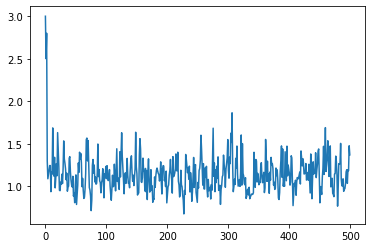

In [128]:
iterations = np.arange(500)

import matplotlib.pyplot as plt 
plt.plot(iterations,L[0])
plt.show()

In [130]:
GAN_output.shape
np.savez_compressed('X_GAN.npz', X_GAN = GAN_output)